In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#reference to https://www.tensorflow.org/tutorials/text/nmt_with_attention
#Copyright 2021 Ichiro Nakamoto

# 基于注意力的神经机器翻译

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pathlib
from matplotlib import rcParams
rcParams['font.family'] = ['Microsoft YaHei']

## 下载和准备数据集

我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：

```

```

这个数据集中有很多种语言可供选择。我们将使用英语 - 中文数据集。为方便使用，我们在谷歌云上提供了此数据集的一份副本。但是你也可以自己下载副本。下载完数据集后，我们将采取下列步骤准备数据：

1. 给每个句子添加一个 *开始* 和一个 *结束* 标记（token）。
2. 删除特殊字符以清理句子。
3. 创建一个单词索引和一个反向单词索引（即一个从单词映射至 id 的词典和一个从 id 映射至单词的词典）。
4. 将每个句子填充（pad）到最大长度。

In [ ]:
# 下载文件
path_to_zip = tf.keras.utils.get_file(
    'cmn-eng.txt', origin='https://firebasestorage.googleapis.com/v0/b/marine-order-311008.appspot.com/o/cmn-eng.txt?alt=media&token=4d856d2f-ea8b-4ba4-9ba2-9e9dfb8d4080',
    cache_subdir='datasets',extract=False)
path_to_file = pathlib.Path(path_to_zip).parent/'cmn-eng.txt'
#path_to_file = "cmn-eng/cmn.txt"
!ls  /root/.keras/datasets/

print(pathlib.Path(path_to_zip).parent)

3620864/3607587 [==============================] - 0s 0us/step
cmn-eng.txt
/root/.keras/datasets


In [ ]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess(text):
    reg = re.compile(r'[a-zA-Z,.?]')
    if reg.match(text):
        text = unicode_to_ascii(text.lower().strip())
        text = re.sub(r"([.!:;,])", r" \1 ", text)
        text = re.sub(r'[" "]+', " ", text)
        text = re.sub(r"[^a-zA-Z?.!,:;]+", " ", text)
    text = text.rstrip().strip()
    text = '<start> ' + text +' <end>'
    return text

In [ ]:
en_sentence = u"Information Technology has achieved great advancement"
sp_sentence = u"信息技术获得巨大进步"
print(preprocess(en_sentence))
print(preprocess(sp_sentence))

<start> information technology has achieved great advancement <end>
<start> 信息技术获得巨大进步 <end>


In [ ]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]
!pip install jieba
import jieba

def  corpus(path, no):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    english=[]
    chinese=[]
    outcome=[]
    for string in lines:
            outcome=string.strip().split('\t')
            english.append('<start> '+ outcome[0]+ ' <end>')
            cnt=jieba.cut(outcome[1], cut_all=False)
            chinese.append('<start> '+ " ".join(cnt) +' <end>')

    return english,chinese

In [ ]:
en, sp = corpus(path_to_file, None)
print(en[100:120])
print(sp[100:120])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.925 seconds.
Prefix dict has been built successfully.


['<start> How cute <end>', '<start> Humor me <end>', '<start> Hurry up <end>', '<start> Hurry up <end>', '<start> Hurry up <end>', '<start> I did it <end>', '<start> I forgot <end>', '<start> I resign <end>', "<start> I'll pay <end>", "<start> I'm back <end>", "<start> I'm busy <end>", "<start> I'm cold <end>", "<start> I'm cool <end>", "<start> I'm fine <end>", "<start> I'm free <end>", "<start> I'm full <end>", "<start> I'm home <end>", "<start> I'm lost <end>", "<start> I'm sick <end>", "<start> I'm sick <end>"]
['<start> 多 可爱 啊 <end>', '<start> 你 就 随 了 我 的 意 吧 <end>', '<start> 趕快 <end>', '<start> 快点 <end>', '<start> 快点 <end>', '<start> 我 做到 了 <end>', '<start> 我 忘 了 <end>', '<start> 我 放弃 <end>', '<start> 我來 付錢 <end>', '<start> 我 回来 了 <end>', '<start> 我 很 忙 <end>', '<start> 我 冷 <end>', '<start> 我 很酷 <end>', '<start> 我 很 好 <end>', '<start> 我 自由 了 <end>', '<start> 我 吃 飽 了 <end>', '<start> 我 在家 裡 <end>', '<start> 我 迷失 了 <end>', '<start> 我 生病 了 <end>', '<start> 我病 了 <end>']


In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = corpus(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 限制数据集的大小以加快实验速度（可选）

在超过 10 万个句子的完整数据集上训练需要很长时间。为了更快地训练，我们可以将数据集的大小限制为 3 万个句子（当然，翻译质量也会随着数据的减少而降低）：

In [ ]:
# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

21110 21110 5278 5278


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d =====> %s" % (t, lang.index_word[t]))

In [ ]:
print ("待翻译语言：索引值和文本映射")
convert(inp_lang, input_tensor_train[0])
print ()
print ("翻译后语言：索引值和文本映射")
convert(targ_lang, target_tensor_train[0])

待翻译语言：索引值和文本映射
1 =====> <start>
3 =====> 我
26 =====> 什么
2864 =====> 经验
23 =====> 都
45 =====> 没有
2 =====> <end>

翻译后语言：索引值和文本映射
1 =====> <start>
4 =====> i
23 =====> don't
17 =====> have
107 =====> any
1139 =====> experience
2 =====> <end>


### 创建一个 tf.data 数据集

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 31]), TensorShape([64, 34]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None,)
    #self.gru = tf.keras.layers.GRU(self.enc_units,
    #                               return_sequences=True,
    #                               return_state=True,
    #                               recurrent_initializer='glorot_uniform')

    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_state=True,
                                   activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.1, recurrent_dropout=0.1, return_sequences=True, 
    go_backwards=False, stateful=False, unroll=False, time_major=False,
    reset_after=True,)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 31, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 隐藏层的形状 == （批大小，隐藏层大小）
    # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
    # 这样做是为了执行加法以计算分数  
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # 分数的形状 == （批大小，最大长度，1）
    # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
    # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
    attention_weights = tf.nn.softmax(score, axis=1)

    # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 31, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.gru = tf.keras.layers.GRU(self.dec_units,
    #                               return_sequences=True,
    #                               return_state=True,
    #                               recurrent_initializer='glorot_uniform')
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_state=True,
                                   activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.1, recurrent_dropout=0.1, return_sequences=True, 
    go_backwards=False, stateful=False, unroll=False, time_major=False,
    reset_after=True,)

    self.fc = tf.keras.layers.Dense(units=vocab_size, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    bias_constraint=None,)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7855)


## 定义优化器和损失函数

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 检查点（基于对象保存）

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

1. 将 *输入* 传送至 *编码器*，编码器返回 *编码器输出* 和 *编码器隐藏层状态*。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 *开始标记*）传送至解码器。
3. 解码器返回 *预测* 和 *解码器隐藏层状态*。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 *教师强制 （teacher forcing）* 决定解码器的下一个输入。
6. *教师强制* 是将 *目标词* 作为 *下一个输入* 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('第 {}轮 第 {} 批 损失值 {:.3}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('第 {} 轮 损失值 {:.3f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('本轮训练时间为 {} 秒 \n'.format(time.time() - start))

第 1轮 第 0 批 损失值 1.97
第 1轮 第 100 批 损失值 1.33
第 1轮 第 200 批 损失值 1.02
第 1轮 第 300 批 损失值 1.18
第 1 轮 损失值 1.149
本轮训练时间为 315.96888422966003 秒 

第 2轮 第 0 批 损失值 0.989
第 2轮 第 100 批 损失值 0.89
第 2轮 第 200 批 损失值 0.875
第 2轮 第 300 批 损失值 0.827
第 2 轮 损失值 0.892
本轮训练时间为 254.1784951686859 秒 

第 3轮 第 0 批 损失值 0.664
第 3轮 第 100 批 损失值 0.682
第 3轮 第 200 批 损失值 0.836
第 3轮 第 300 批 损失值 0.682
第 3 轮 损失值 0.737
本轮训练时间为 253.29778957366943 秒 

第 4轮 第 0 批 损失值 0.608
第 4轮 第 100 批 损失值 0.59
第 4轮 第 200 批 损失值 0.613
第 4轮 第 300 批 损失值 0.494
第 4 轮 损失值 0.589
本轮训练时间为 253.98343181610107 秒 

第 5轮 第 0 批 损失值 0.473
第 5轮 第 100 批 损失值 0.454
第 5轮 第 200 批 损失值 0.464
第 5轮 第 300 批 损失值 0.469
第 5 轮 损失值 0.454
本轮训练时间为 253.28292417526245 秒 

第 6轮 第 0 批 损失值 0.284
第 6轮 第 100 批 损失值 0.315
第 6轮 第 200 批 损失值 0.346
第 6轮 第 300 批 损失值 0.341
第 6 轮 损失值 0.344
本轮训练时间为 253.79479146003723 秒 

第 7轮 第 0 批 损失值 0.224
第 7轮 第 100 批 损失值 0.193
第 7轮 第 200 批 损失值 0.27
第 7轮 第 300 批 损失值 0.296
第 7 轮 损失值 0.253
本轮训练时间为 253.24907898902893 秒 

第 8轮 第 0 批 损失值 0.148
第 8轮 第 100 批 损失值 0.164
第 8轮 

## 翻译

* 评估函数类似于训练循环，不同之处在于在这里我们不使用 *教师强制*。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
* 当模型预测 *结束标记* 时停止预测。
* 存储 *每个时间步的注意力权重*。

请注意：对于一个输入，编码器输出仅计算一次。

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 注意力权重制图函数

from matplotlib.font_manager import FontProperties
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf



# 自定義字體變數
font = FontProperties(fname=r'/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap=plt.get_cmap('Purples'))

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90, fontproperties=font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


    plt.show()

--2021-12-02 01:03:45--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.111.101, 108.177.111.113, 108.177.111.138, ...
Connecting to drive.google.com (drive.google.com)|108.177.111.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/13qv0aqr27tmpv3l28cuecrfq28etvvh/1638407025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-12-02 01:03:49--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/13qv0aqr27tmpv3l28cuecrfq28etvvh/1638407025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.136.132, 2607:f8b0:4001:c34::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|1

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('输入文本: %s' % (sentence))
    print('翻译结果: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 恢复最新的检查点并验证

In [ ]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:

translate('嗨')

findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


输入文本: <start> 嗨 <end>
翻译结果: hi <end> 


输入文本: <start> 他 不幸 找 不到 工作 <end>
翻译结果: he had no luck in finding work <end> 


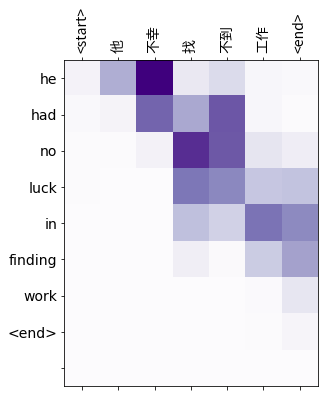

In [ ]:
translate(u'他 不幸 找 不到 工作')

输入文本: <start> 我 想 打 电话 <end>
翻译结果: i'd like to call the telephone <end> 


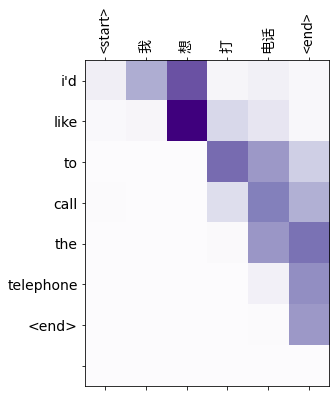

In [ ]:
translate(u'我 想 打 电话')

输入文本: <start> 他 有 了 一个 重要 发现 <end>
翻译结果: he has a grain of truth <end> 


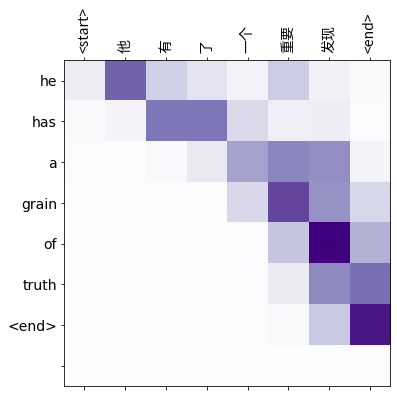

In [ ]:

translate(u'他 有 了 一个 重要 发现')

输入文本: <start> 感谢 你 的 帮助 <end>
翻译结果: thanks for your help <end> 


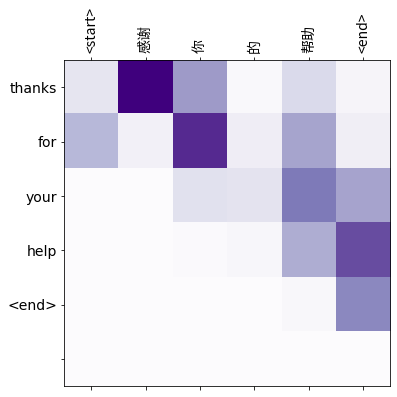

In [ ]:
translate(u'感谢 你 的 帮助')

输入文本: <start> 我 知道 这 对 您 很 重要 <end>
翻译结果: i know this is important to you <end> 


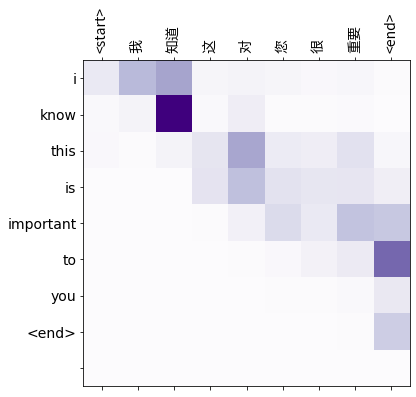

In [ ]:
translate(u'我 知道 这 对 您 很 重要')

输入文本: <start> 运动 有利 健康 <end>
翻译结果: sport is harmful to health <end> 


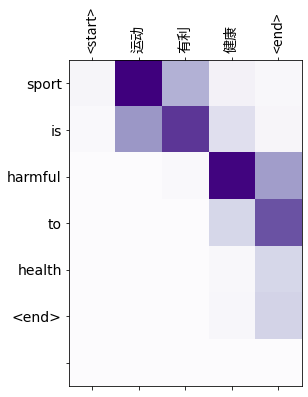

In [ ]:
translate(u'运动 有利 健康')

输入文本: <start> 我 相信 你 的 判断 <end>
翻译结果: i believe your judgment <end> 


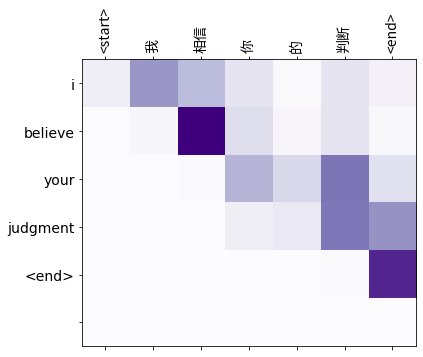

In [ ]:
translate(u'我 相信 你 的 判断')

输入文本: <start> 应该 了解 相应 的 规则 <end>
翻译结果: it knows the rules the rules <end> 


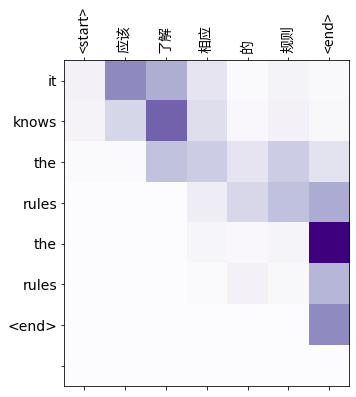

In [ ]:
translate(u'应该 了解 相应 的 规则')

In [ ]:
translate(u'我们 终于 达到 了 目标')

NameError: ignored